In [1]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import humanize
import matplotlib.pyplot as plt
import editdistance
from tqdm import tqdm
from sklearn import manifold


import numpy as np

@FuncFormatter
def duration_fmt(x, pos):
    return humanize.precisedelta(x, minimum_unit='minutes',format='%0.0f')


In [2]:
#fname_global = 'results/realdata/performance_measures/global/csv_files/mds_results.csv.gz'
#df_mds = pd.read_csv(fname_global)

fname_pred = 'results/realdata/performance_measures/global/csv_files//predictions.csv.gz'
df_pred = pd.read_csv(fname_pred)

fname_true = 'results/realdata/performance_measures/global/csv_files//ground_truth.csv.gz'
df_true = pd.read_csv(fname_true)

In [3]:
df_pred['method']

0          predicthaplo_local_haplo
1     cliquesnv_local_haplo_tf0.001
2     cliquesnv_local_haplo_tf0.001
3     cliquesnv_local_haplo_tf0.001
4     cliquesnv_local_haplo_tf0.001
5     cliquesnv_local_haplo_tf0.001
6     cliquesnv_local_haplo_tf0.001
7     cliquesnv_local_haplo_tf0.001
8     cliquesnv_local_haplo_tf0.001
9     cliquesnv_local_haplo_tf0.001
10    cliquesnv_local_haplo_tf0.001
11    cliquesnv_local_haplo_tf0.001
12    cliquesnv_local_haplo_tf0.001
13    cliquesnv_local_haplo_tf0.001
14        viloca_alpha_0.00001_K100
15        viloca_alpha_0.00001_K100
16        viloca_alpha_0.00001_K100
17        viloca_alpha_0.00001_K100
18        viloca_alpha_0.00001_K100
Name: method, dtype: object

### Recompute precision and recall

In [4]:
def relative_edit_distance(seq1, seq2):
    dist = editdistance.eval(seq1[:2262], seq2[:2262])
    rel = dist / max(len(seq1), len(seq2))
    return rel


def pr_worker(index, df_group, df_true, thres):
    (method, params, replicate) = index

    tp = 0
    fp = 0
    fn = 0

    df_true_grpd = df_true[
        (df_true["params"] == params) & (df_true["replicate"] == replicate)
    ]

    # subsample large results
    max_num = 500
    df_group = df_group.sample(n=min(df_group.shape[0], max_num))

    # true positive: predicted seq appears in ground truth
    # false positive: predicted seq does not appear in ground truth
    df_cur = df_true_grpd.copy()
    for row in tqdm(df_group.itertuples(), total=df_group.shape[0], leave=False):
        ser_dist = df_cur["sequence"].apply(
            lambda x: relative_edit_distance(x, row.sequence)
        )
        passed_thres = (ser_dist <= thres).any()

        if passed_thres:
            tp += 1

            # remove ground truth because it was predicted
            df_cur = df_cur.drop(ser_dist.idxmin())
        else:
            fp += 1

    # false negative: ground truth sequence was not predicted
    # single prediction should not map to multiple ground truth seqs
    df_cur = df_group.copy()
    for row in tqdm(
        df_true_grpd.itertuples(), total=df_true_grpd.shape[0], leave=False
    ):
        ser_dist = df_cur["sequence"].apply(
            lambda x: relative_edit_distance(x, row.sequence)
        )
        passed_thres = (ser_dist <= thres).any()

        if not passed_thres:
            fn += 1
        else:
            # remove current prediction
            df_cur = df_cur.drop(ser_dist.idxmin())
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    # finalize
    return {
        "method": method,
        "params": params,
        "replicate": replicate,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": tp / (tp + fp),
        "recall": tp / (tp + fn),
        "f1": 2 * (precision * recall) / (precision + recall), 
    }

In [5]:
distance_threshold = 0.001

In [6]:
0.001*2262

2.262

In [7]:
df_pred = df_pred[df_pred['method'].isin(['cliquesnv_local_haplo_tf0.001', 
                                          'predicthaplo_local_haplo', 
                                          'viloca_alpha_0.00001_K100'])]

In [8]:
tmp = []

for index, df_group in df_pred.groupby(["method", "params", "replicate"]):

    pr_list = pr_worker(index, df_group, df_true, distance_threshold)
    tmp.append(pr_list)
                                                   
df_pr = pd.DataFrame(tmp)  

In [9]:
df_pr

,method,params,replicate,tp,fp,fn,precision,recall,f1
0,cliquesnv_local_haplo_tf0.001,seq_tech~pacbio__seq_mode~amplicon__seq_mode_p...,0,9,4,1,0.692308,0.9,0.782609
1,predicthaplo_local_haplo,seq_tech~pacbio__seq_mode~amplicon__seq_mode_p...,0,1,0,9,1.000000,0.1,0.181818
2,viloca_alpha_0.00001_K100,seq_tech~pacbio__seq_mode~amplicon__seq_mode_p...,0,5,0,5,1.000000,0.5,0.666667


## Recompute mds plot

In [10]:
def mds_worker(index, df_pred_grpd, df_true):
    params, replicate = index

    df_true_grpd = df_true[
        (df_true["params"] == params) & (df_true["replicate"] == replicate)
    ]

    # subsample large results
    max_num = 50

    df_pred_grpd = df_pred_grpd.copy()
    df_pred_grpd = (
        df_pred_grpd.groupby("method")
        .apply(lambda x: x.sample(n=min(len(x), max_num)))
        .reset_index(drop=True)
    )

    # compute dissimilarities
    sequence_list = (
        df_pred_grpd["sequence"].tolist() + df_true_grpd["sequence"].tolist()
    )
    
    sequence_list = [seq[:2262] for seq in sequence_list]

    mat = np.zeros(shape=(len(sequence_list), len(sequence_list)))
    for i, seq1 in enumerate(tqdm(sequence_list, leave=False)):
        for j, seq2 in enumerate(tqdm(sequence_list, leave=False)):
            if i >= j:
                continue

            mat[i, j] = editdistance.eval(seq1, seq2)

    mat = np.triu(mat) + np.tril(mat.T, 1)  # mirror to make symmetric

    # do MDS
    embedding = manifold.MDS(n_components=2, dissimilarity="precomputed")
    mat_trans = embedding.fit_transform(mat)

    df = pd.concat(
        [
            pd.DataFrame(mat_trans, columns=["MDS0", "MDS1"]),
            pd.concat([df_pred_grpd, df_true_grpd], axis=0, ignore_index=True),
        ],
        axis=1,
    )
    df["method"] = df["method"].apply(lambda x: "ground_truth" if x is None else x)
    df["params"] = params
    df["replicate"] = replicate

    return df


def sequence_embedding(df_pred, df_true):
    
    df_list=[]
    for index, df_group in df_pred.groupby(["params", "replicate"]): 
        df_list.append(mds_worker(index, df_group, df_true))

    # finalize
    return pd.concat(df_list, ignore_index=True)


df_mds = sequence_embedding(df_pred, df_true)

  0%|                                                                                                                                                                                | 0/29 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                | 0/29 [00:00<?, ?it/s]
                                                                                                                                                                                                            
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 24/29 [00:05<00:00,  8.99it/s]


  0%|                                                                                                                                                                                | 0/29 [00:00<?, ?it/s]
                                                                                                                                                                                                            
  0%|                                                                                                                                                                                | 0/29 [00:00<?, ?it/s]
                                                                                                                                                                                                            
  0%|                                                                                                                                                                               

## Plot mds

In [11]:
method_palette = { "LoFreq": "#9593D9",
                   "ShoRAH": "#ffe66d",
                   "CliqueSNV":  "#4ecdc4",
                   "VILOCA": "#ff6b6b",
                  "PredictHaplo": "#227c9d",
                   "ground_truth": "grey",
                   "ground truth": "grey",}

mapping_methods = {
    'cliquesnv_local_haplo_snv_tf0.01': "CliqueSNV",
    'cliquesnv_local_haplo_snv': "CliqueSNV",
    'cliquesnv_local_haplo_tf0.01': "CliqueSNV",
    'cliquesnv_local_haplo': "CliqueSNV",
    'shorah_default': 'ShoRAH',
    'lofreq_local_haplo': 'LoFreq',
    'viloca_alpha_0.00001': 'VILOCA',
    'viloca_alpha_0.00001_K100': 'VILOCA',
    'viloca_multi': 'VILOCA',
    'ground_truth': "ground truth",
    'cliquesnv_local_haplo_tf0.001': 'CliqueSNV',
    'predicthaplo_local_haplo': 'PredictHaplo'
}

In [12]:
sns.set_theme(style="white", font_scale=1.8)


def f_freq_bins(x):
    if x >=0.2:
        return 0.3
    elif x>0.1:
        return 0.2
    elif x>0.05:
        return 0.1
    elif x>0.01:
        return 0.05
    elif x<=0.01:
        return 0.01
    
    

df_mds["Frequency"] = df_mds["frequency"].apply(f_freq_bins)
df_mds["Method"] = df_mds['method'].apply(lambda x: mapping_methods[x])

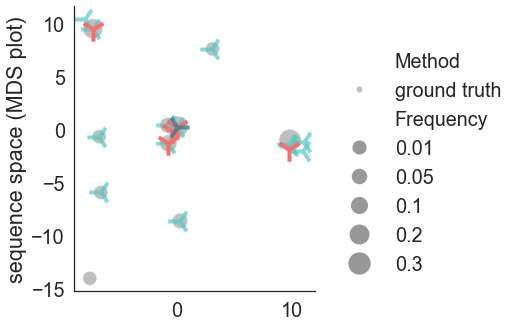

In [69]:
sns.set_theme(style="white", font_scale=1.8)

df_mds = df_mds[df_mds['method'].isin(['cliquesnv_local_haplo_tf0.001',
                                       'predicthaplo_local_haplo',
                                       'viloca_alpha_0.00001_K100', 
                                       'ground_truth'])]



marker_viloca = "1"
marker_cliquesnv = "3"
marker_predicthaplo = "4"


g = sns.relplot(data=df_mds[df_mds['method']=='ground_truth'], 
            kind="scatter", 
            x="MDS1", 
            y="MDS0", 
            size="Frequency",
            hue='Method',
            sizes=(200,500),
            palette={'ground truth': 'gray'},
            alpha=0.5, 
            height=5, 
            aspect=1.0
            )

ax0 = g.fig.axes[0]

df_plot = df_mds[(df_mds['Method'].isin(["CliqueSNV"]))]
ax0.scatter(df_plot["MDS1"], df_plot["MDS0"], marker=marker_cliquesnv, c="#4ecdc4", s=600, linewidth=4, alpha =0.7)

df_plot = df_mds[(df_mds['Method'].isin(["VILOCA"]))]
ax0.scatter(df_plot["MDS1"], df_plot["MDS0"], color="#ff6b6b", marker=marker_viloca,s=600, linewidth=4)

df_plot = df_mds[(df_mds['Method'].isin(["PredictHaplo"]))]
ax0.scatter(df_plot["MDS1"], df_plot["MDS0"], marker=marker_predicthaplo, c="#227c9d", s=600, linewidth=4, alpha =0.7)


g.set_titles(col_template='{col_name}', fontsize=35)

#g.set_xticklabels("")
#g.set_yticklabels("")
g.set(xlabel ="")
g.set(ylabel ="sequence space (MDS plot)")

#g.set(ylim=(-7.5,11), xlim=(-3, 10))
g.tight_layout()

g.savefig("realdata__10iav_mix.svg")


In [54]:
df_mds['method']

0     cliquesnv_local_haplo_tf0.001
1     cliquesnv_local_haplo_tf0.001
2     cliquesnv_local_haplo_tf0.001
3     cliquesnv_local_haplo_tf0.001
4     cliquesnv_local_haplo_tf0.001
5     cliquesnv_local_haplo_tf0.001
6     cliquesnv_local_haplo_tf0.001
7     cliquesnv_local_haplo_tf0.001
8     cliquesnv_local_haplo_tf0.001
9     cliquesnv_local_haplo_tf0.001
10    cliquesnv_local_haplo_tf0.001
11    cliquesnv_local_haplo_tf0.001
12    cliquesnv_local_haplo_tf0.001
13         predicthaplo_local_haplo
14        viloca_alpha_0.00001_K100
15        viloca_alpha_0.00001_K100
16        viloca_alpha_0.00001_K100
17        viloca_alpha_0.00001_K100
18        viloca_alpha_0.00001_K100
19                     ground_truth
20                     ground_truth
21                     ground_truth
22                     ground_truth
23                     ground_truth
24                     ground_truth
25                     ground_truth
26                     ground_truth
27                     groun